# **IRIS 붓꽃 분류: Using KNN**

## **1. 패키지 Import**

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## **2. 데이터 불러오기**

In [24]:
# Load the dataset
wine_data = pd.read_csv('wine.csv', delimiter=';')

# Inspect the dataset
print(wine_data.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

## **3. 학습/검증 데이터 분리 및 특징 선택**

In [25]:
from sklearn.model_selection._split import train_test_split

In [26]:
# Select specific features and target
features = ['alcohol', 'volatile acidity']
X = wine_data[features]
y = wine_data['quality']

In [27]:
# 3. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1279, 2) (320, 2) (1279,) (320,)


## **4. 스케일링**

> **스케일링을 하는 이유?**   
> * 특징 마다 단위가 상이함.   
> * 스케일링은 각 특징의 단위를 ```표준화``` 또는 ```정규화``` 함.

### **표준화: StandardScaler**

* 데이터의 특징을 각각 ```평균이 0```이고, ```분산이 1```인 ```가우시안 정규 분포```를 가진 값으로 변환

In [28]:
from sklearn.preprocessing import StandardScaler

In [29]:
ss_scaler = StandardScaler()
X_train_ss = ss_scaler.fit_transform(X_train)
X_test_ss = ss_scaler.fit_transform(X_test)

## **5. KNN 모델 객체 생성**

* 데이터 선택: X_train/X_test, X_train_ss/X_test_ss

In [30]:

X_train = X_train_ss
X_test = X_test_ss

In [31]:
from sklearn.neighbors import KNeighborsClassifier

In [32]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

* **모델의 하이퍼 파라미터 불러오기**

In [33]:
model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

* **하이퍼 파라미터 튜닝**

In [34]:
model = KNeighborsClassifier(
    n_neighbors = 5,      # 5, 10, 15, ... 등
    weights = 'uniform',   # 'uniform', 'distance' 등
)

In [35]:
model.fit(X_train, y_train)

KNeighborsClassifier()

* **GridSearch를 통한 하이퍼파라미터 튜닝**

In [36]:
from sklearn.model_selection import GridSearchCV

In [37]:
param_grid = {
    "n_neighbors"      : [5, 10, 15],
    "weights"          : ["uniform", "distance"],
}

grid_model = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=2,   # K-fold
    refit=True)

In [38]:
grid_model.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 10, 15],
                         'weights': ['uniform', 'distance']})

In [39]:
# GridSearch 결과 중, 최적 하이퍼파라미터 학습 모델 객체 반환
print(grid_model.best_params_)
best_model = grid_model.best_estimator_

{'n_neighbors': 15, 'weights': 'distance'}


## **6. 모델 평가하기**

* 모델 선택: model, best_model

In [40]:
# model = model
model = best_model

In [41]:
from sklearn.metrics import accuracy_score

In [42]:
y_pred = model.predict(X_test)
print(f'분류 정확도: {accuracy_score(y_test, y_pred)}')

분류 정확도: 0.528125


In [43]:
from sklearn.metrics import classification_report

In [44]:
# Unique classes for target names
quality_labels = sorted(np.unique(y_test))  # Ensure labels are sorted

# Generate classification report
print(classification_report(
    y_test,
    y_pred,
    target_names=[f'Quality {label}' for label in quality_labels]
))

              precision    recall  f1-score   support

   Quality 3       0.00      0.00      0.00         1
   Quality 4       0.00      0.00      0.00        10
   Quality 5       0.59      0.76      0.66       130
   Quality 6       0.50      0.43      0.46       132
   Quality 7       0.38      0.31      0.34        42
   Quality 8       0.00      0.00      0.00         5

    accuracy                           0.53       320
   macro avg       0.24      0.25      0.24       320
weighted avg       0.49      0.53      0.50       320



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **7. 시각화**

> **주의**
> * 2차원으로 시각화 하기 때문에 특징을 2개를 사용하여 학습한 모델만 사용할 것

In [45]:
from matplotlib.colors import ListedColormap

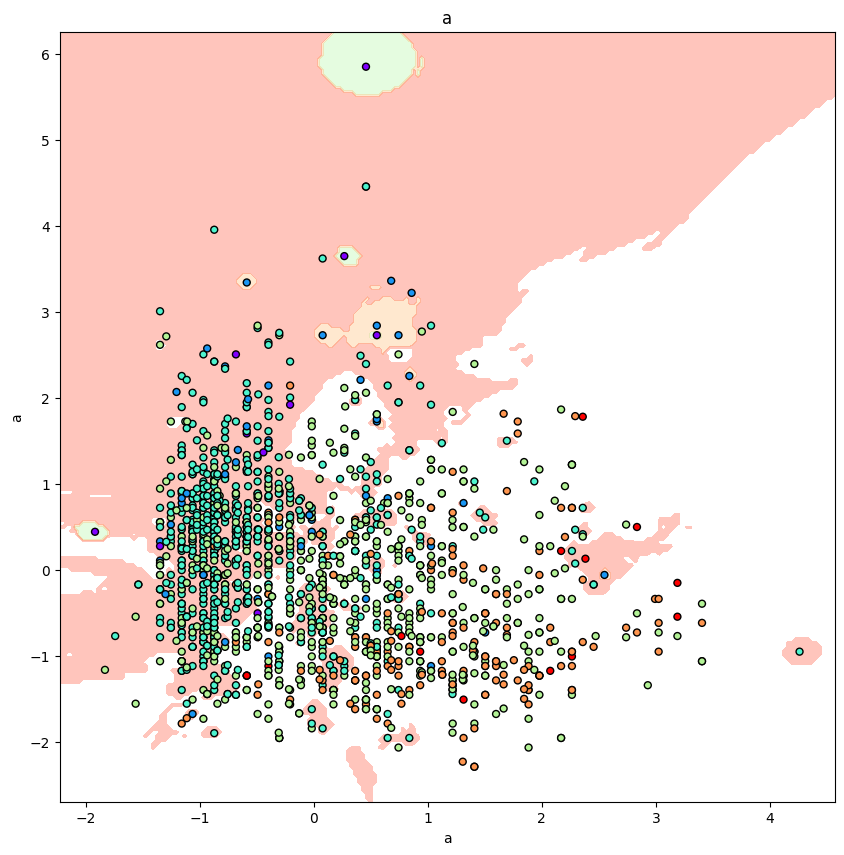

In [46]:
import numpy as np

plt.rcParams['figure.figsize'] = (10, 10)

def visualize_boundary(model, X, y, title, xlabel, ylabel):
    ax = plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k', zorder=3)
    ax.axis('tight')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,levels=np.arange(n_classes + 1) - 0.5,cmap='rainbow',zorder=1)
    plt.title(title)
    plt.xlabel('Alcohol')  # x축 이름 설정
    plt.ylabel('Volatile Acidity')  # y축 이름 설정

visualize_boundary(model, np.vstack([X_train, X_test]), np.hstack([y_train, y_test]), 'a', 'a','a')